In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://github.com/alxndrTL/mamba.py

https://github.com/OpenGVLab/video-mamba-suite

https://github.com/kyegomez/VisionMamba

In [49]:
!pip install -U -q zetascale

In [39]:
import torch, math
import inspect
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, Tensor
from zeta.nn import SSM
from einops.layers.torch import Reduce
from dataclasses import dataclass

In [40]:
"""BiMamba modules"""

@dataclass
class MambaConfig:
    dim: int # The input dimension of the input tensor.
    dt_rank: int = 32 #'auto' # The rank of the state space model.
    dim_inner: int = 256 #None #The dimension of the inner layer of the multi-head attention.
    d_state: int = 256 #None #16 # The dimension of the state space model.
    depth : int = 12 # The number of residual S6 layers
    expand_factor: int = 2 # E in paper/comments
    d_conv : int = 4 # The convolutionnal windows
    rms_norm_eps: float = 1e-5 # Root-mean-square normalization per episode
    
    def __post_init__(self):
        self.d_inner = self.expand_factor * self.dim # E*D = ED in comments
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.dim / self.d_state)

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight
        return output

class BiMambaBlock(nn.Module):
    """
    BiMambaBlock is a module that implements Bidirectional State Space Model
    in.shape == out.shape
    """
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.dim = config.dim
        self.dt_rank = config.dt_rank
        self.dim_inner = config.dim_inner
        self.d_state = config.d_state
        self.d_conv = config.d_conv
        
        # Bi-S6
        self.forward_conv1d = nn.Conv1d(in_channels=self.dim, out_channels=self.dim, kernel_size=self.d_conv) #groups & padding = kernel size?
        self.backward_conv1d = nn.Conv1d(in_channels=self.dim, out_channels=self.dim, kernel_size=self.d_conv) #groups & padding = kernel size?
        self.norm = nn.LayerNorm(self.dim)
        self.silu = nn.SiLU()
        self.ssm = SSM(self.dim, self.dt_rank, self.dim_inner, self.d_state) # Shared

        # Linear layer for z and x
        self.proj = nn.Linear(self.dim, self.dim)
        # Softplus
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor):
        b, s, d = x.shape

        # Skip connection
        skip = x
        # Normalization
        x = self.norm(x)
        # Split x into x1 and x2 with linears
        z1 = self.proj(x)
        x = self.proj(x)
        # forward con1d
        x1 = self.process_direction(x,self.forward_conv1d,self.ssm)
        # backward conv1d
        x2 = self.process_direction(x,self.backward_conv1d,self.ssm)
        # Activation
        z = self.silu(z1)
        # Matmul
        x1 *= z
        x2 *= z
        # Residual connection
        return x1 + x2 + skip

    def process_direction(self,x: Tensor,conv1d: nn.Conv1d,ssm: SSM):
        x = rearrange(x, "b s d -> b d s")
        x = self.softplus(conv1d(x))
        #print(f"Conv1d: {x}")
        x = rearrange(x, "b d s -> b s d")
        x = ssm(x)
        return x

class BiMamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([BiMambaBlock(config) for _ in range(config.depth)])

    def forward(self, x):
        # x : (B, L, D) == y : (B, L, D)
        for layer in self.layers:
            x = layer(x)
        return x
    
    def step(self, x, caches):
        # caches : [cache(layer) for all layers], cache : (h, inputs)
        # initial caches : [(None, torch.zeros(B, self.config.dim_inner, self.config.d_conv-1)) for _ in range(self.config.depth)]
        for i, layer in enumerate(self.layers):
            x, caches[i] = layer.step(x, caches[i])
        return x, caches

class BiMambaLM(nn.Module):
    def __init__(self, model_config: MambaConfig, vocab_size: int):
        super().__init__()
        
        self.config = model_config
        # model
        self.embedding = nn.Embedding(vocab_size, self.config.dim, padding_idx=0)
        self.core = BiMamba(self.config)
        self.out_norm = RMSNorm(self.config.dim, self.config.rms_norm_eps)
        self.lm_head = nn.Linear(self.config.dim, vocab_size, bias=False)
        
        # share & init normal weight
        self.lm_head.weight = self.embedding.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('fc_3.weight') or pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * self.config.depth))
        
    def forward(self, tokens):
        # tokens : (B, L) # logits : (B, L, vocab_size)
        x = self.embedding(tokens)
        x = self.core(x)
        x = self.out_norm(x)
        logits = self.lm_head(x)
        return logits

    def forward_up_to(self, tokens, layer):
        # tokens : (B, L)
        # layer (1->n_layers): will stop the forward pass just after this layer
        # x : (B, L, D) activations after {layer}
        x = self.embedding(tokens)
        x = self.core(x, stop_at_layer=layer)
        return x

    # taken from llama2.c
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # taken from llama2.c
    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # any parameters that is 2D will be weight decayed, otherwise no. (i.e. all weight tensors in matmuls + embeddings decay, all biases and rmnsnorms don't)
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)

        return optimizer

In [47]:
# Model config
vocab_size = 65 # Othello
d_model = 288
n_layers = 8
config = MambaConfig(dim=d_model, depth=n_layers)

# Training config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay = 0.1
lr = 1e-3
adam_b1 = 0.9
adam_b2 = 0.95
dtype = "bfloat16"

In [ ]:
# Othello Dataset (TO DO)

In [55]:
# Initialize model
model = BiMambaLM(config, vocab_size=vocab_size).to(device)
optim = model.configure_optimizers(weight_decay, lr, (adam_b1, adam_b2), device) # AdamW optim with weight_decay except for 1D params (biases, norms)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype=="float16")) # needed when training with float16

In [56]:
model

BiMambaLM(
  (embedding): Embedding(65, 288, padding_idx=0)
  (core): BiMamba(
    (layers): ModuleList(
      (0-7): 8 x BiMambaBlock(
        (forward_conv1d): Conv1d(288, 288, kernel_size=(4,), stride=(1,))
        (backward_conv1d): Conv1d(288, 288, kernel_size=(4,), stride=(1,))
        (norm): LayerNorm((288,), eps=1e-05, elementwise_affine=True)
        (silu): SiLU()
        (ssm): SSM(
          (deltaBC_layer): Linear(in_features=288, out_features=544, bias=False)
          (dt_proj_layer): Linear(in_features=32, out_features=256, bias=True)
        )
        (proj): Linear(in_features=288, out_features=288, bias=True)
        (softplus): Softplus(beta=1, threshold=20)
      )
    )
  )
  (out_norm): RMSNorm()
  (lm_head): Linear(in_features=288, out_features=65, bias=False)
)

In [ ]:
# Train model (TO DO)

In [57]:
# Evaluate model (dummy)
x = torch.randint(high=vocab_size, size=(16, 64))
out = model(x)
print(out.shape)  # Print the shape of the output tensor

RuntimeError: The size of tensor a (256) must match the size of tensor b (288) at non-singleton dimension 2

In [52]:
!pip install -q vision-mamba

In [58]:
from vision_mamba import Vim

# Forward pass
x = torch.randn(1, 3, 224, 224)  # Input tensor with shape (batch_size, channels, height, width)

# Model
vmodel = Vim(
    dim=256,  # Dimension of the transformer model
    dt_rank=32,  # Rank of the dynamic routing matrix
    dim_inner=256,  # Inner dimension of the transformer model
    d_state=256,  # Dimension of the state vector
    num_classes=1000,  # Number of output classes
    image_size=224,  # Size of the input image
    patch_size=16,  # Size of each image patch
    channels=3,  # Number of input channels
    dropout=0.1,  # Dropout rate
    depth=12,  # Depth of the transformer model
)

vmodel

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-11): 12 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=256, out_features=544, bias=False)
        (dt_proj_layer): Linear(in_features=32, out_features=256, bias=True)
      )
      (proj): Linear(in_features=256, out_features=256, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): 

In [60]:
# Forward pass
out = vmodel(x)  # Output tensor from the model
print(out.shape)  # Print the shape of the output tensor
#print(out)  # Print the output tensor

Patch embedding: torch.Size([1, 196, 256])
Cls tokens: torch.Size([1, 1, 256])
torch.Size([1, 196, 256])
Conv1d: tensor([[[0.5546, 0.8219, 0.6970,  ..., 0.6190, 0.6188, 0.4708],
         [0.4961, 0.6966, 0.6320,  ..., 0.5900, 0.9370, 0.4974],
         [0.7610, 0.4622, 0.6065,  ..., 0.9074, 0.7783, 0.6231],
         ...,
         [0.5370, 0.8915, 0.6780,  ..., 0.6211, 1.0476, 1.1674],
         [0.8020, 0.9134, 0.6368,  ..., 0.8923, 0.4767, 0.8751],
         [0.6384, 0.9569, 0.6997,  ..., 0.8845, 0.8580, 1.0755]]],
       grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[0.4462, 0.5545, 0.7961,  ..., 0.7523, 0.5850, 0.5558],
         [0.6507, 0.6031, 0.5236,  ..., 0.5118, 0.4061, 0.6828],
         [0.4994, 0.7751, 0.7581,  ..., 0.5488, 0.7309, 0.6041],
         ...,
         [0.7431, 0.6989, 0.7301,  ..., 0.6591, 0.7016, 0.8692],
         [0.3169, 0.5275, 0.9858,  ..., 0.9103, 1.1685, 0.7174],
         [0.4738, 0.3907, 0.6823,  ..., 0.7801, 0.9884, 0.5471]]],
       grad_fn=<SoftplusBackwar

## To modify :

## Test

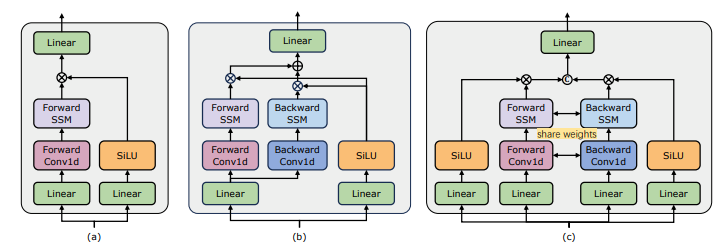